<a href="https://colab.research.google.com/github/sahilmohammed-ai/Deep-Learning-Models/blob/main/Simple_Cancer_CNN_Model_w_Gaussian_Noise_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Initialization

In [1]:
!pip install kagglehub transformers timm -q

import os
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00


In [2]:
import kagglehub
path = kagglehub.dataset_download("obulisainaren/multi-cancer")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/multi-cancer


In [3]:
# Explore file directory structure
!ls "$path"
%cd "$path/Multi Cancer/Multi Cancer/Breast Cancer"
!ls

'Multi Cancer'	 README.md
/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Breast Cancer
breast_benign  breast_malignant


In [4]:
%rm -rf "/content/multi-cancer-subset"

In [5]:
# Assume we want to focus on "Breast Cancer"
# We'll create a subset for demonstration purposes
# Make an easily accessible directory to store our subset
subset_dir = "/content/multi-cancer-subset"
os.makedirs(os.path.join(subset_dir),exist_ok=True)

train_dir = os.path.join(subset_dir, "train")
val_dir = os.path.join(subset_dir, "val")

# Create the necessary directories
os.makedirs(os.path.join(train_dir, "breast_benign"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "breast_malignant"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "breast_benign"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "breast_malignant"), exist_ok=True)

In [6]:
# Prepare to a small number of images from the original dataset to local directory paths
breast_benign_path = os.path.join(path, "Multi Cancer/Multi Cancer/Breast Cancer", "breast_benign")
breast_malignant_path = os.path.join(path, "Multi Cancer/Multi Cancer/Breast Cancer", "breast_malignant")

In [7]:
# Get image files
benign_images = sorted([f for f in os.listdir(breast_benign_path) if f.endswith(".jpg")])
malignant_images = sorted([f for f in os.listdir(breast_malignant_path) if f.endswith(".jpg")])

# Copy images (using only a small subset)
# Let's take 20 images for train and 10 for val from each class.
# You can change the proportion of valuation data out of total data.


for img in benign_images[:20]:
    shutil.copy(os.path.join(breast_benign_path, img), os.path.join(train_dir, "breast_benign"))
for img in benign_images[-10:]:
    shutil.copy(os.path.join(breast_benign_path, img), os.path.join(val_dir, "breast_benign"))

for img in malignant_images[:20]:
    shutil.copy(os.path.join(breast_malignant_path, img), os.path.join(train_dir, "breast_malignant"))
for img in malignant_images[-10:]:
    shutil.copy(os.path.join(breast_malignant_path, img), os.path.join(val_dir, "breast_malignant"))


# # HINT: For making the portion sizing more ubiguitous
# val_data_proportion = 0.2
# num_benign_data = len(benign_images)
# num_malignant_data = len(malignant_images)

In [8]:
print("Created a small train/val subset in:", subset_dir)

Created a small train/val subset in: /content/multi-cancer-subset


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## CNN Model


In [17]:
# 0. Experiment with augmentation techniques
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(), # Convert to Tensor BEFORE RandomErasing
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False) # Apply RandomErasing AFTER ToTensor
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [18]:
# Create datasets from the subset directories
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['breast_benign', 'breast_malignant']


In [67]:
# 1. Defining a new CNN model with Gaussian Noise
class  SimpleCNNGaussianNoise(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNNGaussianNoise, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)


        self.gaussian_noise = nn.Sequential(
            transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
            transforms.RandomRotation(15)
        )

        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))


        if self.training:
            x = self.gaussian_noise(x)

        x = x.view(-1, 64 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

gaussian_noise_model = SimpleCNNGaussianNoise(num_classes=len(class_names)).to(device)
print(gaussian_noise_model)

SimpleCNNGaussianNoise(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gaussian_noise): Sequential(
    (0): RandomPerspective(p=0.5)
    (1): RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
  )
  (fc1): Linear(in_features=200704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [68]:
# 2. Train new model using the train_and_validate function
import matplotlib.pyplot as plt

# Function to train and validate a model, returning history of losses and accuracies
def train_and_validate(model, optimizer, criterion, train_loader, val_loader, num_epochs=2, device='cpu', model_name='Model'):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += labels.size(0)

        # TODO
        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        # ENDTODO

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels).item()
                val_total += labels.size(0)

        # TODO
        val_loss = val_running_loss / val_total
        val_acc = val_running_corrects / val_total
        # ENDTODO

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }



cnn_bn_optimizer = optim.Adam(gaussian_noise_model.parameters(), lr=0.001)
cnn_bn_criterion = nn.CrossEntropyLoss()
cnn_bn_num_epochs = 10

cnn_bn_history = train_and_validate(gaussian_noise_model, cnn_bn_optimizer, cnn_bn_criterion,
                                    train_loader, val_loader,
                                    num_epochs=cnn_bn_num_epochs, device=device, model_name="CNN+BN")


[CNN+BN] Epoch 1/10 - Train Loss: 2.0091, Train Acc: 0.5000, Val Loss: 1.3141, Val Acc: 0.6000
[CNN+BN] Epoch 2/10 - Train Loss: 1.2368, Train Acc: 0.5750, Val Loss: 2.0255, Val Acc: 0.5000
[CNN+BN] Epoch 3/10 - Train Loss: 0.4896, Train Acc: 0.7000, Val Loss: 1.5150, Val Acc: 0.4000
[CNN+BN] Epoch 4/10 - Train Loss: 0.4997, Train Acc: 0.7750, Val Loss: 1.5286, Val Acc: 0.4500
[CNN+BN] Epoch 5/10 - Train Loss: 0.3292, Train Acc: 0.9500, Val Loss: 3.7766, Val Acc: 0.5000
[CNN+BN] Epoch 6/10 - Train Loss: 0.3696, Train Acc: 0.8000, Val Loss: 2.4566, Val Acc: 0.5500
[CNN+BN] Epoch 7/10 - Train Loss: 0.1265, Train Acc: 1.0000, Val Loss: 2.2436, Val Acc: 0.4500
[CNN+BN] Epoch 8/10 - Train Loss: 0.3304, Train Acc: 0.8500, Val Loss: 3.5247, Val Acc: 0.5000
[CNN+BN] Epoch 9/10 - Train Loss: 0.4729, Train Acc: 0.8250, Val Loss: 10.0142, Val Acc: 0.5000
[CNN+BN] Epoch 10/10 - Train Loss: 0.7523, Train Acc: 0.7750, Val Loss: 5.1542, Val Acc: 0.5500


In [69]:
# 3. Evaluate the new model
gaussian_noise_model.eval()
val_running_corrects = 0
val_total = 0
gaussian_noise_all_preds = []
gaussian_noise_all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = gaussian_noise_model(inputs)
        _, preds = torch.max(outputs, 1)
        val_running_corrects += torch.sum(preds == labels).item()
        val_total += labels.size(0)
        gaussian_noise_all_preds.append(preds.cpu().numpy())
        gaussian_noise_all_labels.append(labels.cpu().numpy())

gaussian_noise_val_acc = val_running_corrects / val_total
print(f"[CNN with Noise] Validation Accuracy: {gaussian_noise_val_acc:.4f}")

gaussian_noise_all_preds = np.concatenate(gaussian_noise_all_preds)
gaussian_noise_all_labels = np.concatenate(gaussian_noise_all_labels)

[CNN with Noise] Validation Accuracy: 0.5500


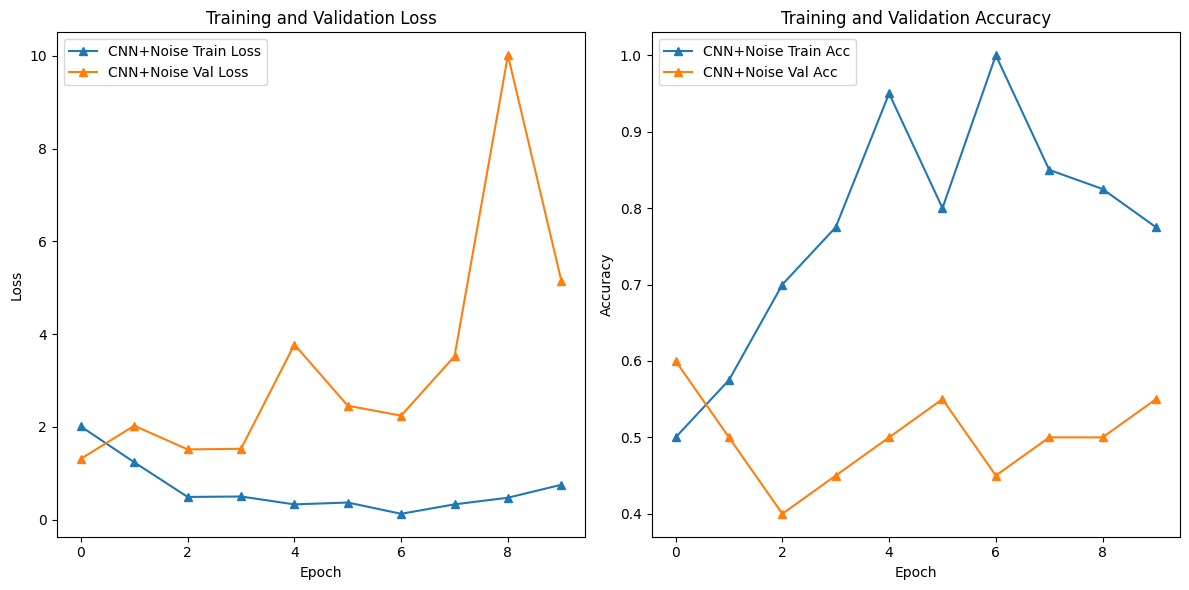

In [70]:
# 4. Graphing the performance of the model (using the plotting function)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_bn_history['train_loss'], label='CNN+Noise Train Loss', marker='^')
plt.plot(cnn_bn_history['val_loss'], label='CNN+Noise Val Loss', marker='^')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_bn_history['train_acc'], label='CNN+Noise Train Acc', marker='^')
plt.plot(cnn_bn_history['val_acc'], label='CNN+Noise Val Acc', marker='^')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()